In [398]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

In [399]:
a = 0
b = 1
K = 3
N = 50

N_train = int(N/3*2)
mean = 1
var = 0.1

In [400]:
def x_split(X, Y, N_train):
    N = len(X)

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    return Xtrain, Xtest, Ytrain, Ytest

In [401]:
def phi(X, K):
    N = len(X)
    V = np.zeros((N, K))
    for i in range(K):
        V[:,i] = X**i
    return V

def create_set(K=K, N=N, a=a, b=b, var=var):    
    X = np.linspace(a, b, N)
    theta_true = np.ones((K,))

    e = np.random.normal(0, var, N)

    Y = phi(X, K) @ theta_true + e
    return X, Y

In [402]:
def grad_f_MLE(X, Y, theta):
    K = len(theta)
    return phi(X, K).T @ ((phi(X, K) @ theta) - Y)

def grad_f_MAP(lam):
    return lambda X, Y, theta: phi(X, len(theta)).T @ ((phi(X, len(theta)) @ theta) - Y) + 2 * lam * theta

In [403]:
def theta_calc_eq(phi_X, Y):
    first_fact = phi_X.T @ phi_X
    second_fact = phi_X.T @ Y
    try:
        L = scipy.linalg.choleksy(first_fact, lower = True)
        y = scipy.linalg.solve_triangular(L, b, lower = True)
        theta_found_normeq = scipy.linalg.solve_triangular(L.T, y)
    except:
        theta_found_normeq = np.linalg.solve(first_fact, second_fact)
    return theta_found_normeq

In [404]:
def theta_calc_eq_map(phi_X, Y, lam, K):
    first_fact = phi_X.T @ phi_X + (lam * np.eye(K))
    second_fact = phi_X.T @ Y
    try:
        L = scipy.linalg.choleksy(first_fact, lower = True)
        y = scipy.linalg.solve_triangular(L, b, lower = True)
        theta_found_normeq = scipy.linalg.solve_triangular(L.T, y)
    except:
        theta_found_normeq = np.linalg.solve(first_fact, second_fact)
    return theta_found_normeq

In [405]:
def GD(x0, D, grad_f, tolf=1e-6, tolx=1e-6, kmax=10000000, alpha=1e-5):
    k=0
    (X, Y) = D
    xk = x0

    xs = [xk]
    grad_vals = [grad_f(X, Y, xk)]

    while (np.linalg.norm(grad_f(X, Y, xk)) >= tolf and k < kmax - 1):
        x_prec = xk
        xk = x_prec - (alpha * grad_f(X, Y, x_prec))

        xs.append(xk)
        grad_vals.append(grad_f(X, Y, xk))

        if np.linalg.norm(grad_vals[-1]) < tolf:
            break
            
        if np.linalg.norm(xk - xs[-1]) < tolx:
            break
            
        k+=1
    
    return xk


In [406]:
def shuffle(X, Y):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    new_X = X[idx]
    new_Y = Y[idx]

    return new_X, new_Y

def SGD(w0, D, grad_f, batch_size = 5, n_epochs = 10, alpha = 1e-5):
    (X, Y) = D
    N = len(X)

    n_batch_per_epoch = N//batch_size

    w = np.array(w0)
    ws = [w]

    for epoch in range(n_epochs):
        X_new, Y_new = shuffle(X, Y)

        for batch in range(n_batch_per_epoch):
            n = batch * batch_size
            m = (batch+1) * batch_size
            Mx = X_new[n:m]
            My = Y_new[n:m]

            w = w - (alpha * grad_f(Mx, My, w))
            ws.append(w)
    
    return w


In [407]:
X, Y = create_set()
X_train, X_test, Y_train, Y_test = x_split(X, Y, N_train)
D = (X, Y)

In [408]:
def MLE(D, K, method):
    X, Y = D
    theta = None
    if method == "NE":
        theta = theta_calc_eq(phi(X, K), Y)
    if method == "GD":
        theta = GD(np.ones((K,)), D, grad_f_MLE)
    if method == "SGD":
        w0 = np.random.normal(mean, var, K)
        theta = SGD(w0, D, grad_f_MLE)
    return theta

In [409]:
def MAP(D, K, lam, method):
    X, Y = D
    theta = None
    if method == "NE":
        theta = theta_calc_eq_map(phi(X, K), Y, lam, K)
    if method == "GD":
        theta = GD(np.ones((K,)), D, grad_f_MAP(lam))
    if method == "SGD":
        w0 = np.random.normal(mean, var, K)
        theta = SGD(w0, D, grad_f_MAP(lam))
    return theta

In [410]:
def fixed_f(X, K, theta):
    return phi(X, K) @ theta

def avg_abs_err(theta, D):
    X, Y = D
    K = len(theta)
    return (np.linalg.norm(fixed_f(X, K, theta) - Y)**2) * 1/N

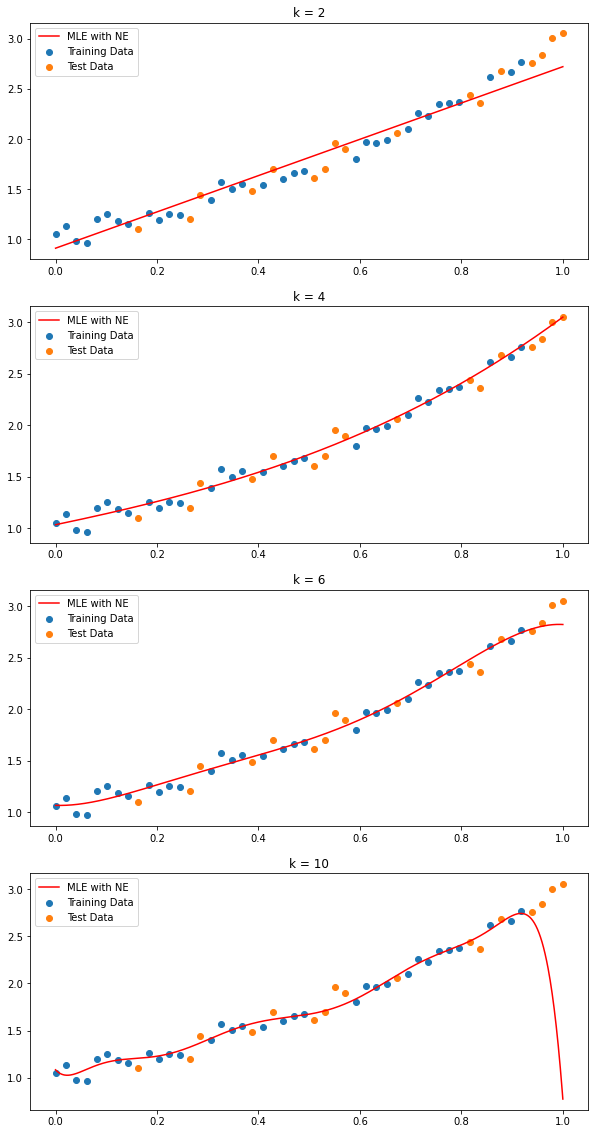

In [411]:
ks_mle = [2, 4, 6, 10]
thetas_mle = []
methods = ["NE", "NE", "NE", "NE"]
errs_train_mle = []
errs_test_mle = []

for i, k in enumerate(ks_mle):
    thetas_mle.append(MLE((X_train, Y_train), k, methods[i]))
    errs_train_mle.append(avg_abs_err(thetas_mle[-1], (X_train, Y_train)))
    errs_test_mle.append(avg_abs_err(thetas_mle[-1], (X_test, Y_test)))

fig, ax = plt.subplots(len(ks_mle), figsize = (10, 20))

for i in range(len(ks_mle)):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = fixed_f(X_plot, ks_mle[i], thetas_mle[i])
    ax[i].plot(X_plot, Y_plot, label = f"MLE with {methods[i]}", color="red")
    ax[i].scatter(X_train, Y_train, label="Training Data")
    ax[i].scatter(X_test, Y_test, label = "Test Data")
    ax[i].set_title("k = " + str(ks_mle[i]))
    ax[i].legend()

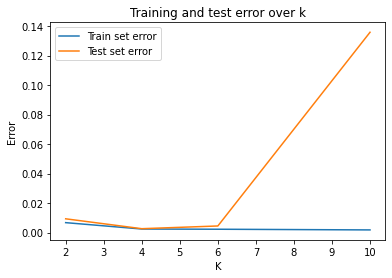

In [412]:
plt.plot(ks_mle, errs_train_mle, label = "Train set error")
plt.plot(ks_mle, errs_test_mle, label = "Test set error")
plt.legend()
plt.title("Training and test error over k")
plt.xlabel("K")
plt.ylabel("Error")
plt.show()

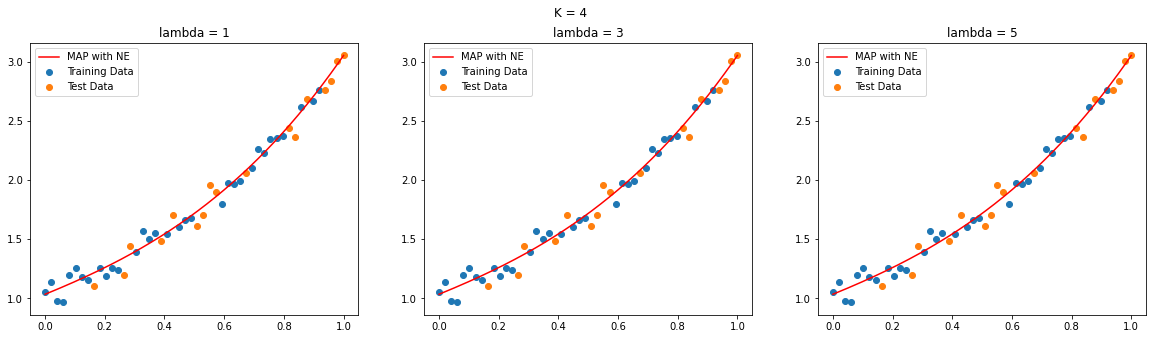

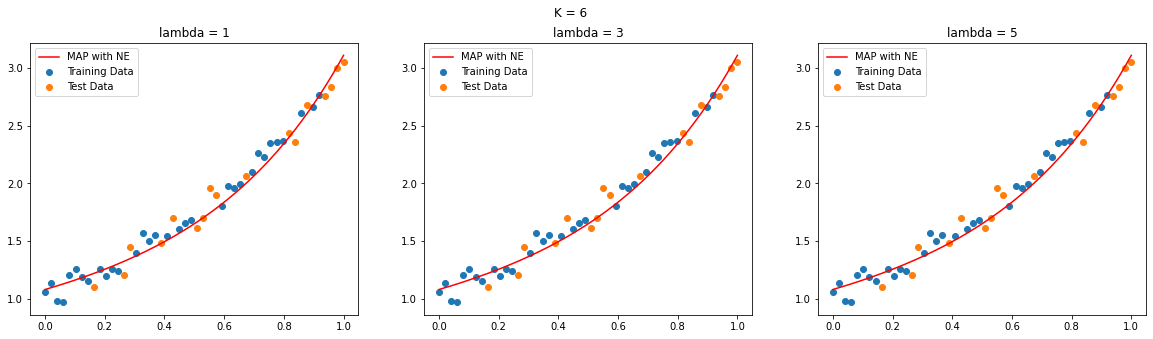

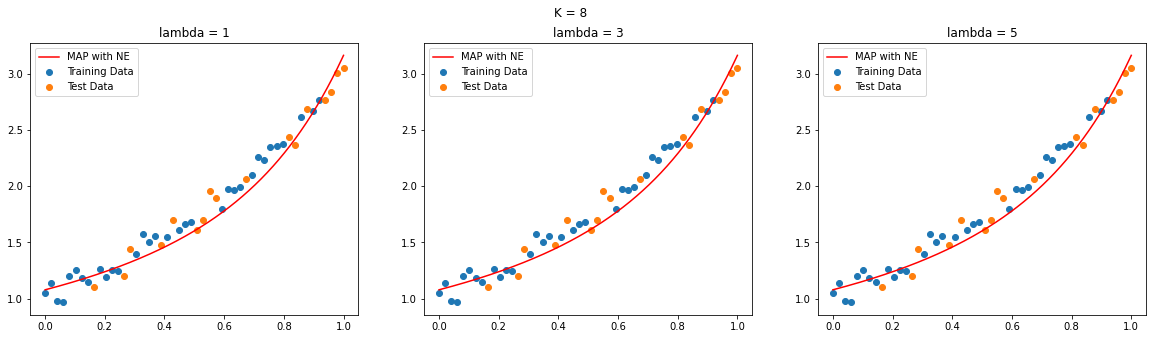

In [413]:
ks_map = [4, 6, 8]
thetas_map = []
methods = ["NE", "NE", "NE"]
lams = [1, 3, 5]

for i, k in enumerate(ks_map):
    thetas_map_l = []
    for lam in lams:
        thetas_map_l.append(MAP((X_train, Y_train), k, i, methods[i]))
    thetas_map.append(thetas_map_l)

for i, k in enumerate(ks_map):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K = {k}")
    for j, lam in enumerate(lams):
        theta_map = thetas_map[i][j]
        X_plot = np.linspace(a, b, 1000)
        Y_plot = fixed_f(X_plot, k, theta_map)
        plt.subplot(1, 3, j+1)
        plt.plot(X_plot, Y_plot, label=f"MAP with {methods[i]}", color="red")
        plt.scatter(X_train, Y_train, label= "Training Data")
        plt.scatter(X_test, Y_test, label="Test Data")
        plt.title(f"lambda = {lam}")
        plt.legend() 

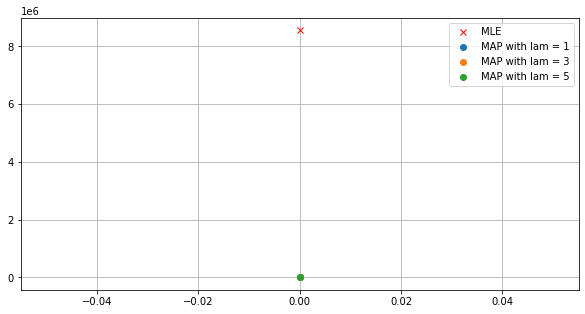

In [422]:
K_bigger = 30

theta_mle_bigger = MLE((X_train, Y_train), K_bigger, "NE")
thetas_map_bigger = [MAP((X_train, Y_train), K_bigger, lam, "NE") for lam in lams] 

mle_error = avg_abs_err(theta_mle_bigger, (X_test, Y_test))
map_errors = [avg_abs_err(theta, (X_test, Y_test)) for theta in thetas_map_bigger]

plt.figure(figsize = (10, 5))
plt.plot(mle_error, 'xr', label = "MLE")
for i, lam in enumerate(lams):
    plt.plot(map_errors[i], 'o', label=f"MAP with lam = {lam}")
plt.legend()
plt.grid()

In [415]:
def err(theta, k):
    t_len = len(theta)
    theta_true = np.concatenate((np.ones((k, )), np.zeros((t_len-k,))))
    return ((np.linalg.norm(theta - theta_true))/(np.linalg.norm(theta_true)))

<Figure size 432x288 with 0 Axes>

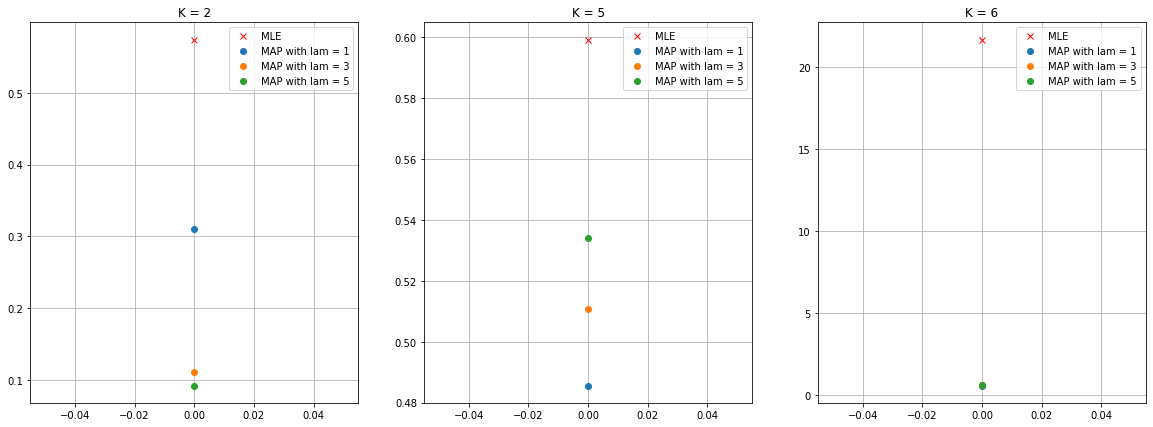

In [416]:
ks = [2, 5, 6]
lams = [1, 3, 5]

plt.suptitle("Theta Errors")
plt.figure(figsize = (20, 7))
for i, k in enumerate(ks):
    theta_mle = MLE((X_train, Y_train), k, "NE")
    thetas_map = [MAP((X_train, Y_train), k, lam, "NE") for lam in lams]

    mle_error = err(theta_mle, k)
    map_errors = [err(theta_map, k) for theta_map in thetas_map]

    plt.subplot(1, len(ks), i + 1)
    plt.plot(mle_error, 'xr', label="MLE")

    for i, lam in enumerate(lams):
        plt.plot(map_errors[i], 'o', label=f"MAP with lam = {lam}")
    plt.legend()
    plt.grid()
    plt.title(f"K = {k}")

In [417]:
testMLE = MLE((X_train, Y_train), K, "GD")
print(f"Theta MLE GD: {testMLE}")
testMLE = MLE((X_train, Y_train), K, "SGD")
print(f"Theta MLE SGD: {testMLE}")
testMLE = MLE((X_train, Y_train), K, "NE")
print(f"Theta MLE NE: {testMLE}")

print()

testMAP = MAP((X_train, Y_train), K, 1, "GD")
print(f"Theta MAP GD: {testMAP}")
testMAP = MAP((X_train, Y_train), K, 1, "SGD")
print(f"Theta MAP SGD: {testMAP}")
testMAP = MAP((X_train, Y_train), K, 1, "NE")
print(f"Theta MAP NE: {testMAP}")

Theta MLE GD: [0.99999817 0.99999696 0.99999781]
Theta MLE SGD: [0.92271558 0.82114387 1.01585016]
Theta MLE NE: [1.05592153 0.72541458 1.21331796]

Theta MAP GD: [0.99997817 0.99997696 0.99997781]
Theta MAP SGD: [0.81470613 1.00647957 0.83660732]
Theta MAP NE: [1.0504072  0.93592696 0.77440167]
